# Flight Delay Prediction: Feature Engineering

## 1. Setup and Data Loading

In [2]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys

# visualization settings
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.2)
%matplotlib inline

# set up project paths
project_dir = Path.cwd().parents[1]
data_raw = os.path.join(project_dir, 'data', 'raw')
data_processed = os.path.join(project_dir, 'data', 'processed')

# add src directory to path to import project modules
sys.path.insert(0, os.path.join(project_dir))

# silence warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load the training data
train_data_path = os.path.join(data_raw, 'flight_delays_train.csv')
df = pd.read_csv(train_data_path)

# check the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (100000, 9)


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


## 2. Data Preprocessing

In [4]:
# convert data types
def convert_data_types(df):
    """Convert data types and clean the input dataframe."""
    df_out = df.copy()
    
    # remove 'c-' prefix and convert to integers
    if isinstance(df_out['Month'].iloc[0], str) and 'c-' in df_out['Month'].iloc[0]:
        df_out['Month'] = df_out['Month'].str.replace('c-', '').astype(int)
        df_out['DayofMonth'] = df_out['DayofMonth'].str.replace('c-', '').astype(int)
        df_out['DayOfWeek'] = df_out['DayOfWeek'].str.replace('c-', '').astype(int)
    
    # convert target variable if it's Y/N
    if 'dep_delayed_15min' in df_out.columns and df_out['dep_delayed_15min'].dtype == object:
        df_out['dep_delayed_15min'] = df_out['dep_delayed_15min'].map({'Y': 1, 'N': 0})
    
    return df_out

# apply the function
df_clean = convert_data_types(df)

# check the updated data types
df_clean.dtypes

Month                 int64
DayofMonth            int64
DayOfWeek             int64
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min     int64
dtype: object

In [5]:
# confirm no missing values
missing = df_clean.isnull().sum()
print("Missing values per column:")
missing[missing > 0]

Missing values per column:


Series([], dtype: int64)

## 3. Temporal Feature Engineering

In [6]:
def create_temporal_features(df):
    """Create time-based features from the flight data."""
    # create a copy to avoid modifying the original
    df_out = df.copy()
    
    # extract hour and minute from departure time
    df_out['dep_hour'] = df_out['DepTime'] // 100
    df_out['dep_minute'] = df_out['DepTime'] % 100
    
    # time of day categories
    df_out['time_period'] = pd.cut(
        df_out['dep_hour'], 
        bins=[0, 5, 11, 17, 23],
        labels=['Night', 'Morning', 'Afternoon', 'Evening']
    )
    
    # weekend indicator
    df_out['is_weekend'] = (df_out['DayOfWeek'] >= 6).astype(int)
    
    # season from month
    seasons = {
        1: 'Winter', 2: 'Winter', 3: 'Spring', 
        4: 'Spring', 5: 'Spring', 6: 'Summer',
        7: 'Summer', 8: 'Summer', 9: 'Fall', 
        10: 'Fall', 11: 'Fall', 12: 'Winter'
    }
    df_out['season'] = df_out['Month'].map(seasons)
    
    # create month-day string for holiday detection
    df_out['month_day'] = df_out['Month'].astype(str).str.zfill(2) + '-' + df_out['DayofMonth'].astype(str).str.zfill(2)
    
    # US Holiday indicators
    us_holidays = [
        '01-01',  # New Year's Day
        '01-15',  # Martin Luther King Jr. Day (third Monday in January, approximated)
        '02-14',  # Valentine's Day
        '02-15',  # Presidents' Day (third Monday in February, approximated)
        '03-17',  # St. Patrick's Day

        # Easter varies by year but falls between March 22 and April 25
        # I'll include common dates in this range
        '04-05',  # Easter approximation (early April)
        '04-15',  # Easter approximation (mid April)
    
        '05-05',  # Cinco de Mayo
        '05-25',  # Memorial Day (last Monday in May, approximated)
        '06-19',  # Juneteenth
        '07-04',  # Independence Day
        '09-01',  # Labor Day (first Monday in September, approximated)
        '10-31',  # Halloween
        '11-11',  # Veterans Day
        '11-25',  # Thanksgiving (fourth Thursday in November, approximated)
        '11-26',  # Black Friday
        '12-24',  # Christmas Eve
        '12-25',  # Christmas Day
        '12-31',  # New Year's Eve
    ]
    df_out['is_holiday'] = df_out['month_day'].isin(us_holidays).astype(int)
    
    # peak travel seasons
    summer_peak = (df_out['Month'] >= 6) & (df_out['Month'] <= 8)
    winter_holiday = ((df_out['Month'] == 12) & (df_out['DayofMonth'] >= 15)) | ((df_out['Month'] == 1) & (df_out['DayofMonth'] <= 5))
    df_out['is_peak_travel_season'] = (summer_peak | winter_holiday).astype(int)
    
    return df_out

# apply temporal feature engineering
df_temporal = create_temporal_features(df_clean)

# display new columns
new_cols = [col for col in df_temporal.columns if col not in df_clean.columns]
print(f"New temporal features: {new_cols}")
df_temporal[new_cols].head()

New temporal features: ['dep_hour', 'dep_minute', 'time_period', 'is_weekend', 'season', 'month_day', 'is_holiday', 'is_peak_travel_season']


,dep_hour,dep_minute,time_period,is_weekend,season,month_day,is_holiday,is_peak_travel_season
0,19,34,Evening,1,Summer,08-21,0,1
1,15,48,Afternoon,0,Spring,04-20,0,0
2,14,22,Afternoon,0,Fall,09-02,0,0
3,10,15,Morning,1,Fall,11-25,1,0
4,18,28,Evening,1,Fall,10-07,0,0


### Visualizing Temporal Features

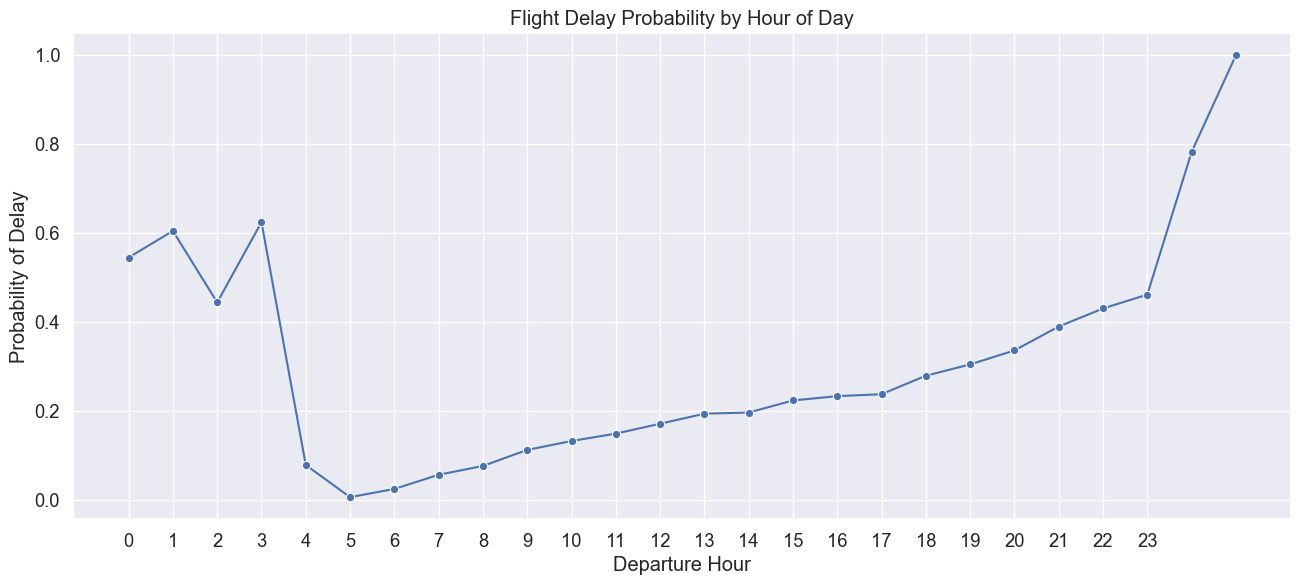

In [7]:
# analyze delays by hour of day
plt.figure(figsize=(14, 6))
hourly_delays = df_temporal.groupby('dep_hour')['dep_delayed_15min'].mean()
sns.lineplot(x=hourly_delays.index, y=hourly_delays.values, marker='o')
plt.title('Flight Delay Probability by Hour of Day')
plt.xlabel('Departure Hour')
plt.ylabel('Probability of Delay')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

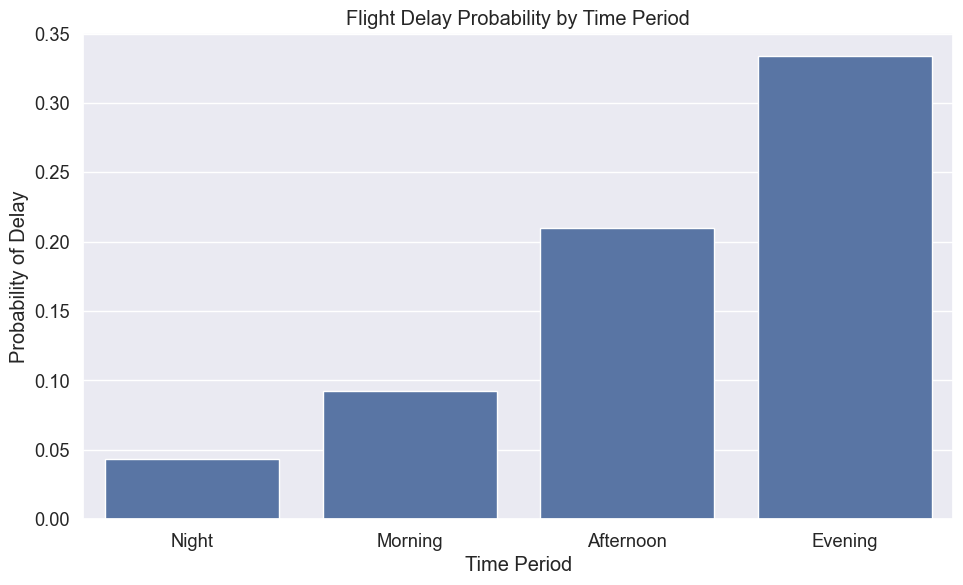

In [8]:
# analyze delays by time period
plt.figure(figsize=(10, 6))
period_delays = df_temporal.groupby('time_period')['dep_delayed_15min'].mean().sort_values()
sns.barplot(x=period_delays.index, y=period_delays.values)
plt.title('Flight Delay Probability by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Probability of Delay')
plt.show()

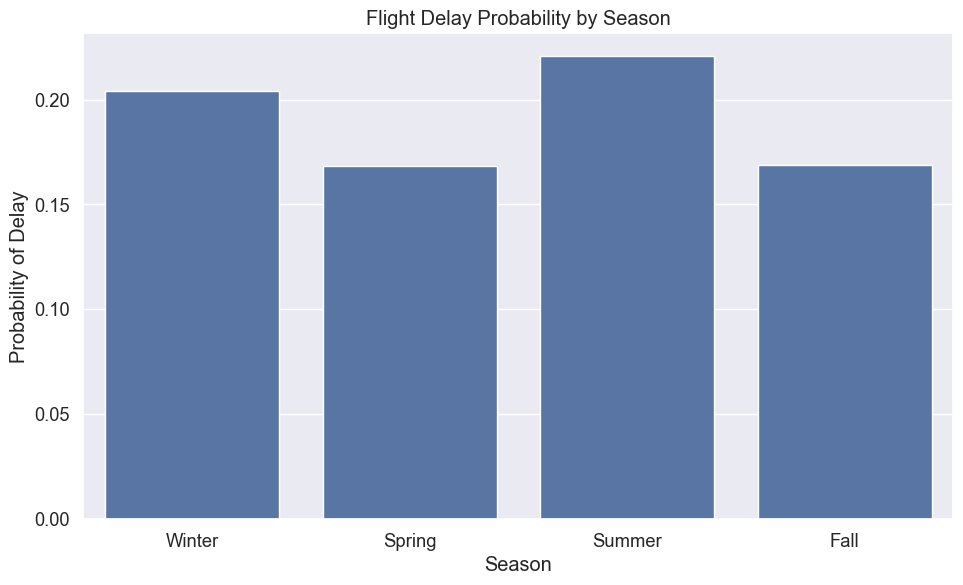

In [9]:
# analyze delays by season
plt.figure(figsize=(10, 6))
season_delays = df_temporal.groupby('season')['dep_delayed_15min'].mean()
# reorder seasons for logical flow
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
season_delays = season_delays.reindex(season_order)
sns.barplot(x=season_delays.index, y=season_delays.values)
plt.title('Flight Delay Probability by Season')
plt.xlabel('Season')
plt.ylabel('Probability of Delay')
plt.show()

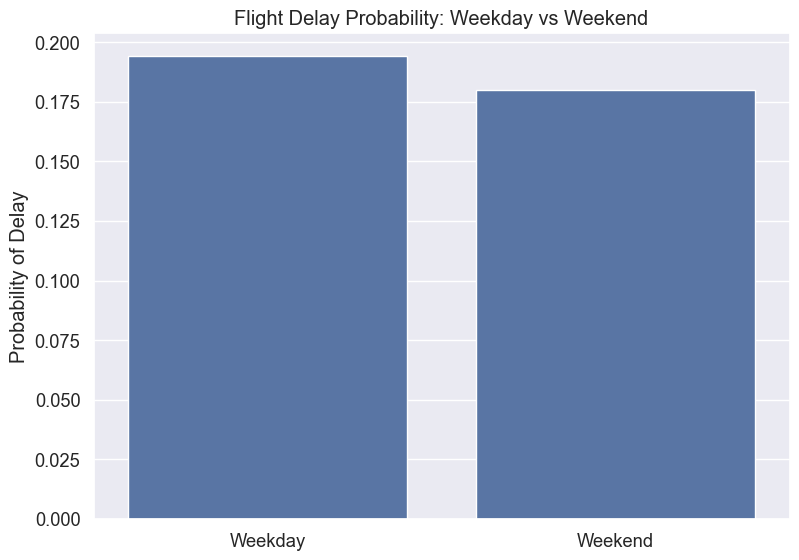

In [10]:
# compare weekday vs weekend delays
plt.figure(figsize=(8, 6))
weekend_labels = ['Weekday', 'Weekend']
weekend_delays = df_temporal.groupby('is_weekend')['dep_delayed_15min'].mean()
sns.barplot(x=[weekend_labels[i] for i in weekend_delays.index], y=weekend_delays.values)
plt.title('Flight Delay Probability: Weekday vs Weekend')
plt.xlabel('')
plt.ylabel('Probability of Delay')
plt.show()

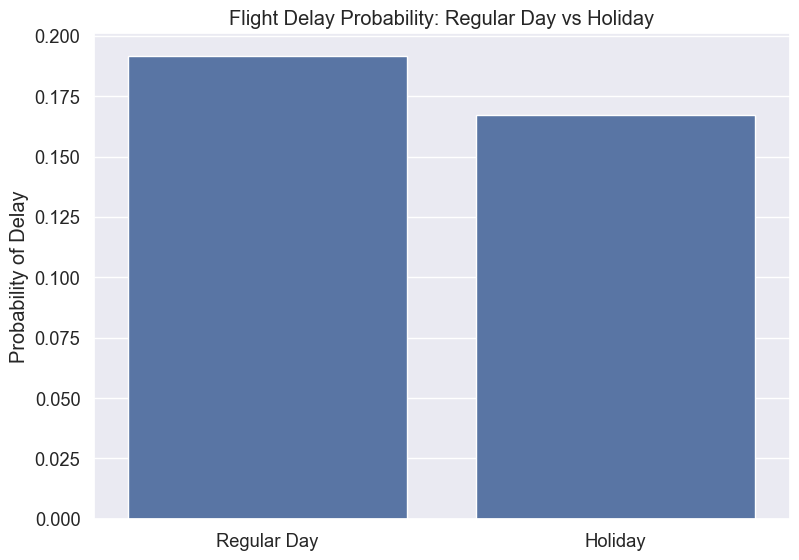

In [11]:
# holiday vs non-holiday delays
plt.figure(figsize=(8, 6))
holiday_labels = ['Regular Day', 'Holiday']
holiday_delays = df_temporal.groupby('is_holiday')['dep_delayed_15min'].mean()
sns.barplot(x=[holiday_labels[i] for i in holiday_delays.index], y=holiday_delays.values)
plt.title('Flight Delay Probability: Regular Day vs Holiday')
plt.xlabel('')
plt.ylabel('Probability of Delay')
plt.show()

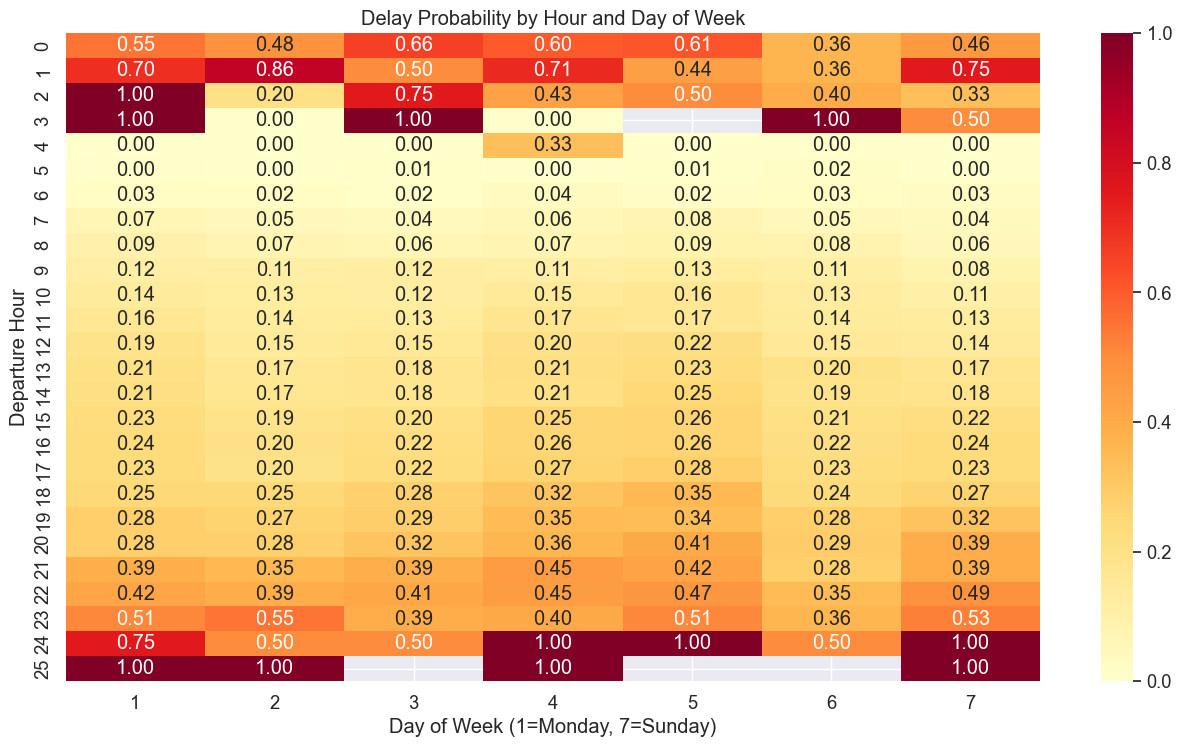

In [12]:
# day of week and hour heatmap
plt.figure(figsize=(14, 8))
hour_day_pivot = pd.pivot_table(
    df_temporal,
    values='dep_delayed_15min',
    index='dep_hour',
    columns='DayOfWeek',
    aggfunc='mean'
)
sns.heatmap(hour_day_pivot, cmap='YlOrRd', annot=True, fmt=".2f")
plt.title('Delay Probability by Hour and Day of Week')
plt.xlabel('Day of Week (1=Monday, 7=Sunday)')
plt.ylabel('Departure Hour')
plt.show()

## 4. Airport and Spatial Feature Engineering

In [13]:
def create_airport_features(df):
    """Create airport and route-related features."""
    df_out = df.copy()
    
    # airport frequency - how busy are these airports?
    origin_counts = df.groupby('Origin').size()
    dest_counts = df.groupby('Dest').size()
    
    # convert to percentile ranks for better generalization
    origin_ranks = origin_counts.rank(pct=True)
    dest_ranks = dest_counts.rank(pct=True)
    
    df_out['origin_freq_rank'] = df_out['Origin'].map(origin_ranks)
    df_out['dest_freq_rank'] = df_out['Dest'].map(dest_ranks)
    
    # airport delay statistics
    origin_delay_rates = df.groupby('Origin')['dep_delayed_15min'].mean()
    dest_delay_rates = df.groupby('Dest')['dep_delayed_15min'].mean()
    
    df_out['origin_delay_rate'] = df_out['Origin'].map(origin_delay_rates)
    df_out['dest_delay_rate'] = df_out['Dest'].map(dest_delay_rates)
    
    # hub airport indicators (top 10 by frequency)
    top_origins = origin_counts.nlargest(10).index
    top_dests = dest_counts.nlargest(10).index
    
    df_out['origin_is_hub'] = df_out['Origin'].isin(top_origins).astype(int)
    df_out['dest_is_hub'] = df_out['Dest'].isin(top_dests).astype(int)
    
    # create route features
    df_out['route'] = df_out['Origin'] + '_' + df_out['Dest']
    
    # route statistics
    route_counts = df.groupby(['Origin', 'Dest']).size()
    route_ranks = route_counts.rank(pct=True)
    
    # handle route mapping
    route_map = {(o, d): r for (o, d), r in zip(route_ranks.index, route_ranks.values)}
    df_out['route_freq_rank'] = df_out.apply(lambda x: route_map.get((x['Origin'], x['Dest']), np.nan), axis=1)
    
    # route delay rates
    route_delay_rates = df.groupby(['Origin', 'Dest'])['dep_delayed_15min'].mean()
    route_delay_map = {(o, d): r for (o, d), r in zip(route_delay_rates.index, route_delay_rates.values)}
    df_out['route_delay_rate'] = df_out.apply(lambda x: route_delay_map.get((x['Origin'], x['Dest']), np.nan), axis=1)
    
    # distance-based features
    df_out['distance_category'] = pd.cut(
        df_out['Distance'],
        bins=[0, 300, 600, 1000, 2000, 5000],
        labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long']
    )
    
    return df_out

# apply airport feature engineering
df_spatial = create_airport_features(df_temporal)

# display new columns
new_cols = [col for col in df_spatial.columns if col not in df_temporal.columns]
print(f"New spatial features: {new_cols}")
df_spatial[new_cols].head()

New spatial features: ['origin_freq_rank', 'dest_freq_rank', 'origin_delay_rate', 'dest_delay_rate', 'origin_is_hub', 'dest_is_hub', 'route', 'route_freq_rank', 'route_delay_rate', 'distance_category']


,origin_freq_rank,dest_freq_rank,origin_delay_rate,dest_delay_rate,origin_is_hub,dest_is_hub,route,route_freq_rank,route_delay_rate,distance_category
0,1.000000,0.993080,0.258142,0.151257,1,1,ATL_DFW,0.994920,0.235294,Medium
1,0.858131,0.944637,0.171512,0.184028,0,0,PIT_MCO,0.912396,0.166667,Medium
2,0.885813,0.910035,0.184332,0.175698,0,0,RDU_CLE,0.636600,0.090909,Short
3,0.982699,0.847751,0.193407,0.149444,1,0,DEN_MEM,0.467035,0.142857,Medium
4,0.920415,0.788927,0.251098,0.260450,0,0,MDW_OMA,0.750056,0.466667,Short


### Visualizing Spatial Features

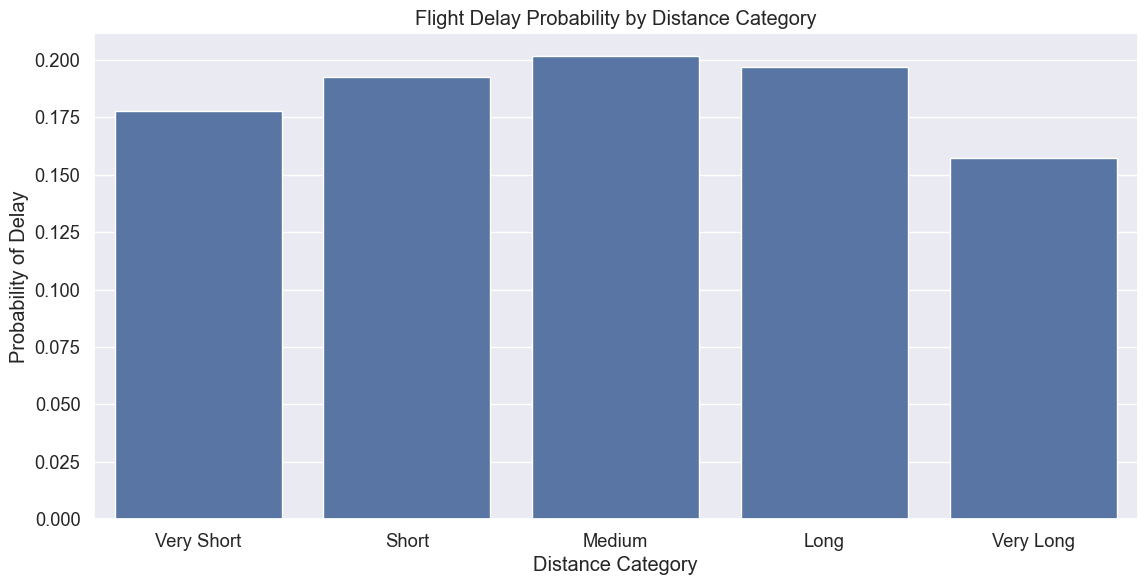

In [14]:
# analyze delays by distance category
plt.figure(figsize=(12, 6))
distance_delays = df_spatial.groupby('distance_category')['dep_delayed_15min'].mean()
sns.barplot(x=distance_delays.index, y=distance_delays.values)
plt.title('Flight Delay Probability by Distance Category')
plt.xlabel('Distance Category')
plt.ylabel('Probability of Delay')
plt.show()

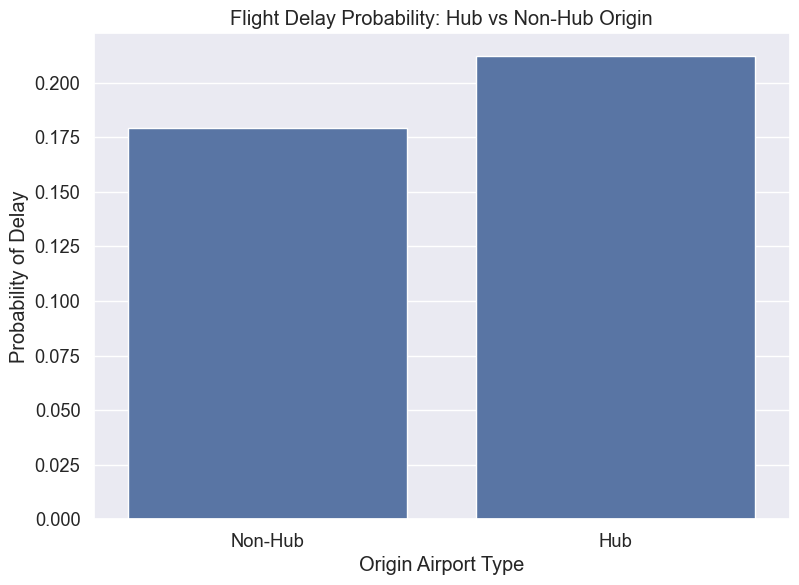

In [15]:
# hub vs non-hub origin airports
plt.figure(figsize=(8, 6))
hub_labels = ['Non-Hub', 'Hub']
hub_delays = df_spatial.groupby('origin_is_hub')['dep_delayed_15min'].mean()
sns.barplot(x=[hub_labels[i] for i in hub_delays.index], y=hub_delays.values)
plt.title('Flight Delay Probability: Hub vs Non-Hub Origin')
plt.xlabel('Origin Airport Type')
plt.ylabel('Probability of Delay')
plt.show()

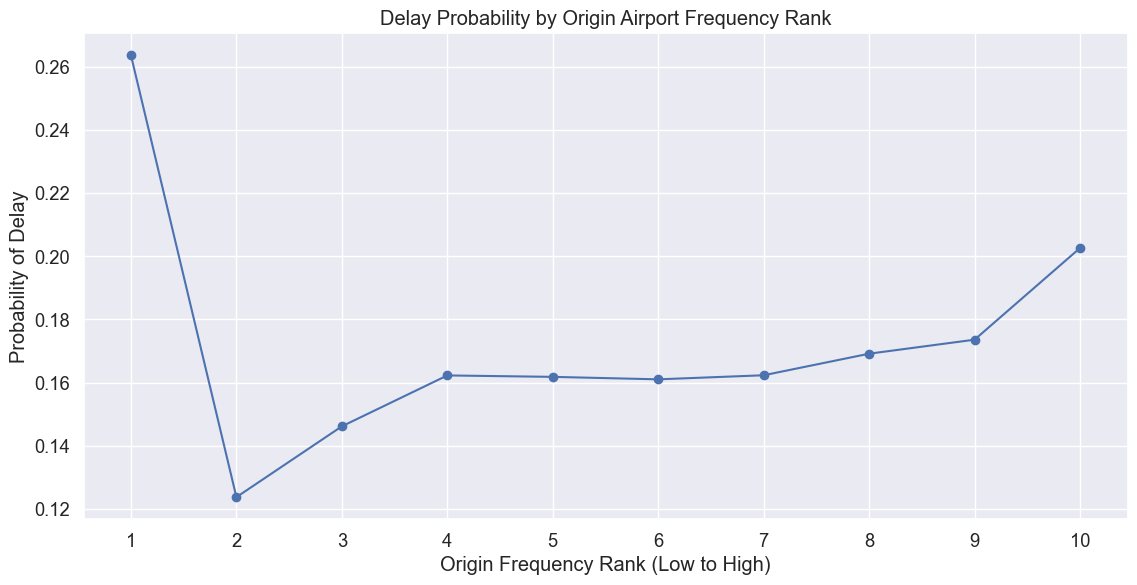

In [16]:
# origin frequency rank vs delay probability
plt.figure(figsize=(12, 6))
# create bins for better visualization
df_spatial['origin_freq_bins'] = pd.cut(df_spatial['origin_freq_rank'], bins=10)
origin_bin_delays = df_spatial.groupby('origin_freq_bins')['dep_delayed_15min'].mean()

# plot
plt.plot(range(len(origin_bin_delays)), origin_bin_delays.values, marker='o')
plt.title('Delay Probability by Origin Airport Frequency Rank')
plt.xlabel('Origin Frequency Rank (Low to High)')
plt.ylabel('Probability of Delay')
plt.xticks(range(len(origin_bin_delays)), labels=[f"{i+1}" for i in range(len(origin_bin_delays))])
plt.grid(True)
plt.show()

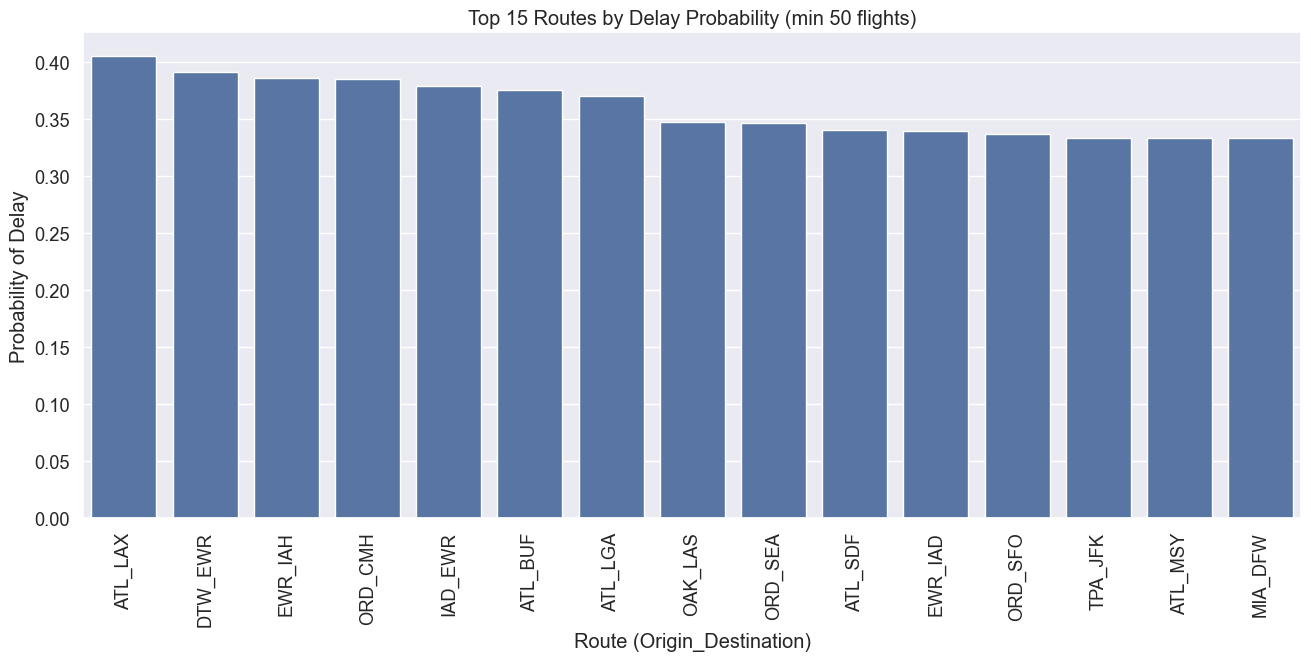

In [17]:
# top 15 routes by delay rate
plt.figure(figsize=(14, 6))
# only consider routes with at least 50 flights
route_counts = df_spatial['route'].value_counts()
common_routes = route_counts[route_counts >= 50].index
common_route_data = df_spatial[df_spatial['route'].isin(common_routes)]

route_delays = common_route_data.groupby('route')['dep_delayed_15min'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=route_delays.index, y=route_delays.values)
plt.title('Top 15 Routes by Delay Probability (min 50 flights)')
plt.xlabel('Route (Origin_Destination)')
plt.ylabel('Probability of Delay')
plt.xticks(rotation=90)
plt.show()

## 5. Carrier Feature Engineering

In [18]:
def create_carrier_features(df):
    """Create carrier-related features."""
    df_out = df.copy()
    
    # carrier size and frequency
    carrier_counts = df['UniqueCarrier'].value_counts()
    carrier_rank = carrier_counts.rank(pct=True)
    
    df_out['carrier_size_rank'] = df_out['UniqueCarrier'].map(carrier_rank)
    
    # carrier delay rates
    carrier_delay_rates = df.groupby('UniqueCarrier')['dep_delayed_15min'].mean()
    df_out['carrier_delay_rate'] = df_out['UniqueCarrier'].map(carrier_delay_rates)
    
    # create carrier-specific time features
    if 'dep_hour' in df_out.columns:
        # calculate carrier performance by time of day
        carrier_hour_delay = df.groupby(['UniqueCarrier', 'dep_hour'])['dep_delayed_15min'].mean().reset_index()
        carrier_hour_map = dict(zip(zip(carrier_hour_delay['UniqueCarrier'], carrier_hour_delay['dep_hour']), 
                                  carrier_hour_delay['dep_delayed_15min']))
        
        df_out['carrier_hour_performance'] = df_out.apply(
            lambda x: carrier_hour_map.get((x['UniqueCarrier'], x['dep_hour']), np.nan), axis=1
        )
    
    # create carrier-route performance features
    carrier_route_counts = df.groupby(['UniqueCarrier', 'Origin', 'Dest']).size().reset_index(name='carrier_route_count')
    
    # merge this information back
    df_out = pd.merge(
        df_out, 
        carrier_route_counts,
        on=['UniqueCarrier', 'Origin', 'Dest'],
        how='left'
    )
    
    # calculate carrier performance on specific routes
    carrier_route_perf = df.groupby(['UniqueCarrier', 'Origin', 'Dest'])['dep_delayed_15min'].mean().reset_index(name='carrier_route_delay_rate')
    
    # merge performance back
    df_out = pd.merge(
        df_out,
        carrier_route_perf,
        on=['UniqueCarrier', 'Origin', 'Dest'],
        how='left'
    )
    
    # fill missing values
    df_out['carrier_route_count'] = df_out['carrier_route_count'].fillna(0)
    df_out['carrier_route_delay_rate'] = df_out['carrier_route_delay_rate'].fillna(df_out['carrier_delay_rate'])
    
    return df_out

# apply carrier feature engineering
df_carrier = create_carrier_features(df_spatial)

# display new columns
new_cols = [col for col in df_carrier.columns if col not in df_spatial.columns]
print(f"New carrier features: {new_cols}")
df_carrier[new_cols].head()

New carrier features: ['carrier_size_rank', 'carrier_delay_rate', 'carrier_hour_performance', 'carrier_route_count', 'carrier_route_delay_rate']


,carrier_size_rank,carrier_delay_rate,carrier_hour_performance,carrier_route_count,carrier_route_delay_rate
0,0.954545,0.187938,0.304255,56,0.250000
1,0.727273,0.167387,0.158924,31,0.161290
2,0.636364,0.173869,0.184987,22,0.090909
3,0.818182,0.172801,0.155738,12,0.083333
4,1.000000,0.213433,0.347082,30,0.466667


### Visualizing Carrier Features

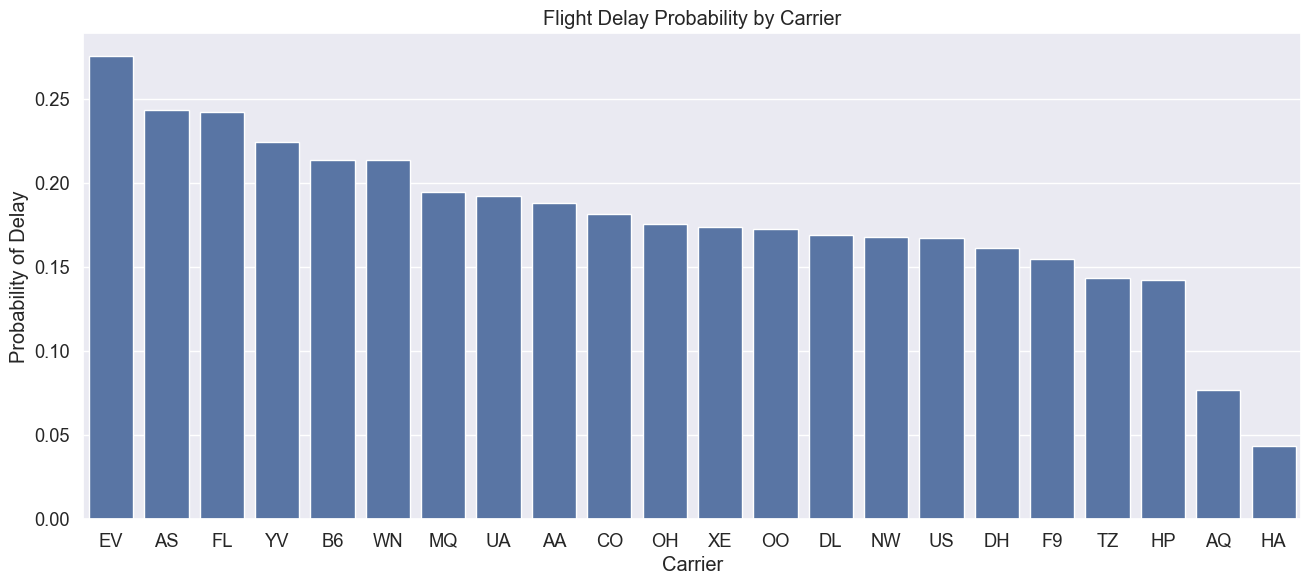

In [19]:
# carrier delay rates
plt.figure(figsize=(14, 6))
carrier_delays = df_carrier.groupby('UniqueCarrier')['dep_delayed_15min'].mean().sort_values(ascending=False)
sns.barplot(x=carrier_delays.index, y=carrier_delays.values)
plt.title('Flight Delay Probability by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Probability of Delay')
plt.show()

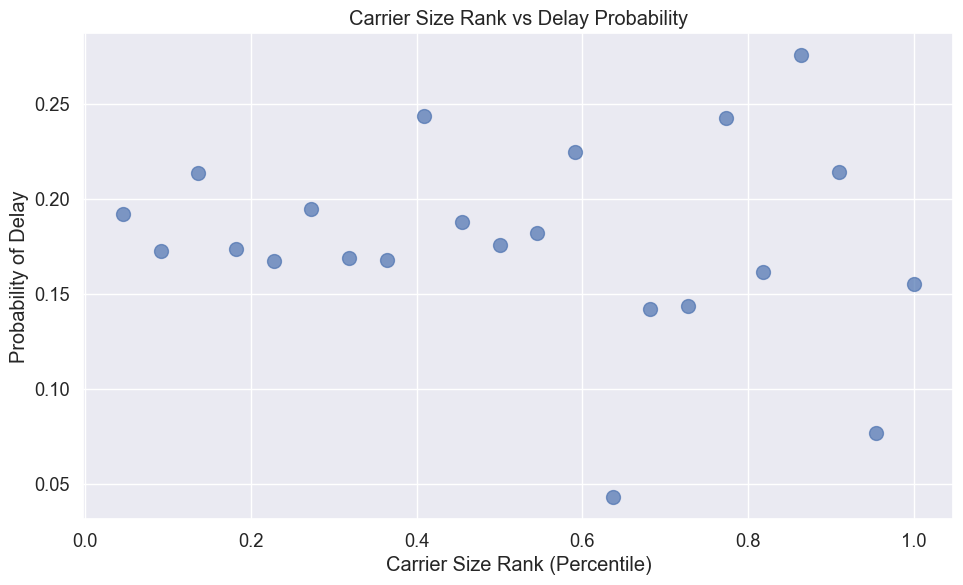

In [20]:
# carrier size vs delay rate
plt.figure(figsize=(10, 6))
plt.scatter(
    df_carrier['carrier_size_rank'].unique(),
    df_carrier.groupby('carrier_size_rank')['dep_delayed_15min'].mean(),
    alpha=0.7,
    s=100
)
plt.title('Carrier Size Rank vs Delay Probability')
plt.xlabel('Carrier Size Rank (Percentile)')
plt.ylabel('Probability of Delay')
plt.grid(True)
plt.show()

<Figure size 1400x800 with 0 Axes>

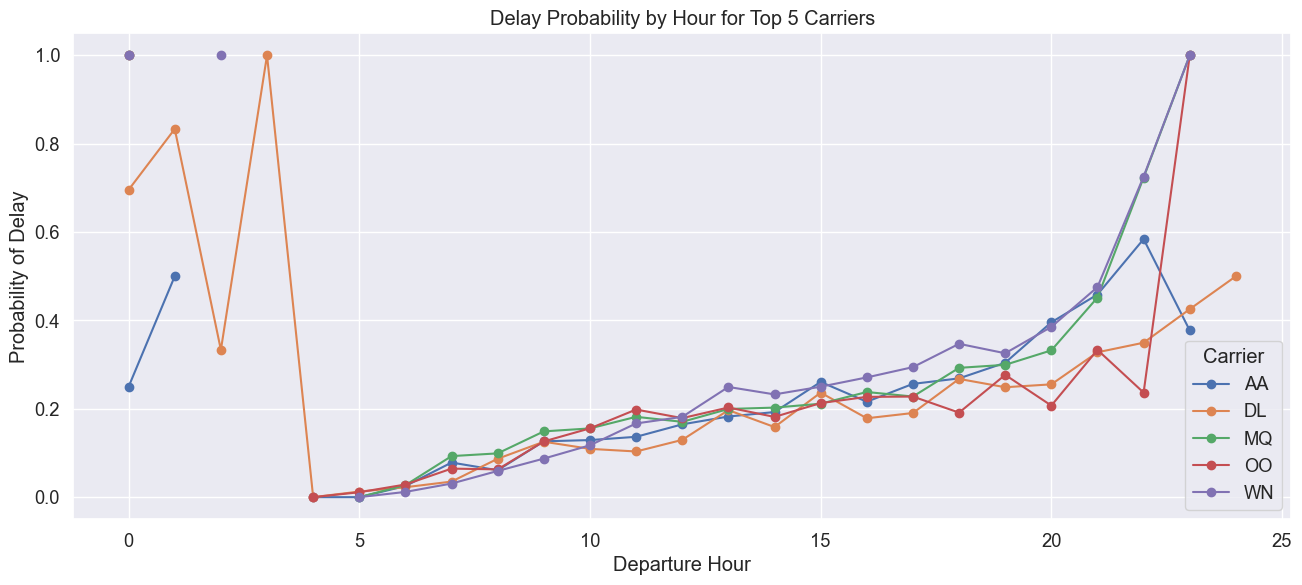

In [21]:
# top carriers' performance by time of day
plt.figure(figsize=(14, 8))
top_carriers = df_carrier['UniqueCarrier'].value_counts().nlargest(5).index
top_carrier_data = df_carrier[df_carrier['UniqueCarrier'].isin(top_carriers)]

# create pivot table
carrier_hour_pivot = pd.pivot_table(
    top_carrier_data,
    values='dep_delayed_15min',
    index='dep_hour',
    columns='UniqueCarrier',
    aggfunc='mean'
)

# plot
carrier_hour_pivot.plot(figsize=(14, 6), marker='o')
plt.title('Delay Probability by Hour for Top 5 Carriers')
plt.xlabel('Departure Hour')
plt.ylabel('Probability of Delay')
plt.grid(True)
plt.legend(title='Carrier')
plt.show()

## 6. Interaction Features

In [ ]:
def create_interaction_features(df):
    """Create interaction features."""
    df_out = df.copy()
    
    # hub-to-hub flights
    df_out['hub_to_hub'] = df_out['origin_is_hub'] * df_out['dest_is_hub']
    
    # peak season on weekend
    df_out['peak_weekend'] = df_out['is_weekend'] * df_out['is_peak_travel_season']
    
    # high-traffic carrier at hub
    df_out['carrier_at_hub'] = (df_out['carrier_size_rank'] > 0.8) * df_out['origin_is_hub']
    
    # evening/night flights on weekends
    df_out['evening_weekend'] = ((df_out['time_period'] == 'Evening') | (df_out['time_period'] == 'Night')) * df_out['is_weekend']
    
    # long distance flights during peak travel
    df_out['long_distance_peak'] = ((df_out['distance_category'] == 'Long') | (df_out['distance_category'] == 'Very Long')) * df_out['is_peak_travel_season']
    
    # problematic carrier on problematic route
    df_out['high_risk_combo'] = (df_out['carrier_delay_rate'] > df_out['carrier_delay_rate'].mean()) & \
                               (df_out['route_delay_rate'] > df_out['route_delay_rate'].mean())
    df_out['high_risk_combo'] = df_out['high_risk_combo'].astype(int)
    
    return df_out

# apply interaction feature engineering
df_full = create_interaction_features(df_carrier)

# display new columns
new_cols = [col for col in df_full.columns if col not in df_carrier.columns]
print(f"New interaction features: {new_cols}")
df_full[new_cols].head()

New interaction features: ['hub_to_hub', 'peak_weekend', 'carrier_at_hub', 'evening_weekend', 'long_distance_peak', 'high_risk_combo']


,hub_to_hub,peak_weekend,carrier_at_hub,evening_weekend,long_distance_peak,high_risk_combo
0,1,1,1,1,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,1,0,0,0
4,0,0,0,1,0,1


### Visualizing Interaction Features

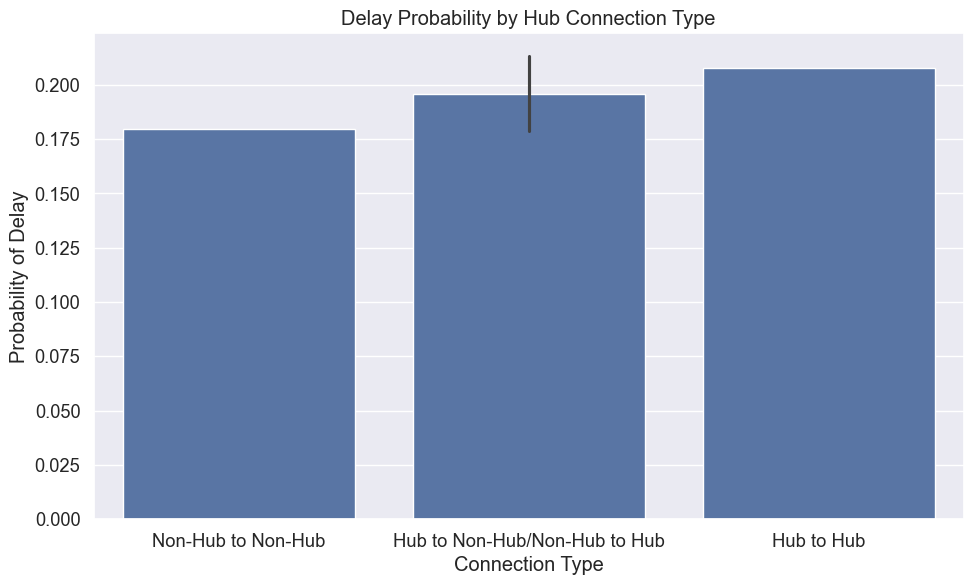

In [23]:
# hub-to-hub flights
plt.figure(figsize=(10, 6))
hub_to_hub_labels = ['Non-Hub to Non-Hub', 'Hub to Non-Hub/Non-Hub to Hub', 'Hub to Hub']
hub_to_hub_groups = df_full.groupby(['origin_is_hub', 'dest_is_hub'])['dep_delayed_15min'].mean().reset_index()

# create the categories
hub_to_hub_groups['category'] = hub_to_hub_groups.apply(
    lambda x: 'Hub to Hub' if x['origin_is_hub'] and x['dest_is_hub'] else \
             ('Non-Hub to Non-Hub' if not x['origin_is_hub'] and not x['dest_is_hub'] else \
              'Hub to Non-Hub/Non-Hub to Hub'), axis=1
)

# plot
sns.barplot(x='category', y='dep_delayed_15min', data=hub_to_hub_groups, order=hub_to_hub_labels)
plt.title('Delay Probability by Hub Connection Type')
plt.xlabel('Connection Type')
plt.ylabel('Probability of Delay')
plt.show()

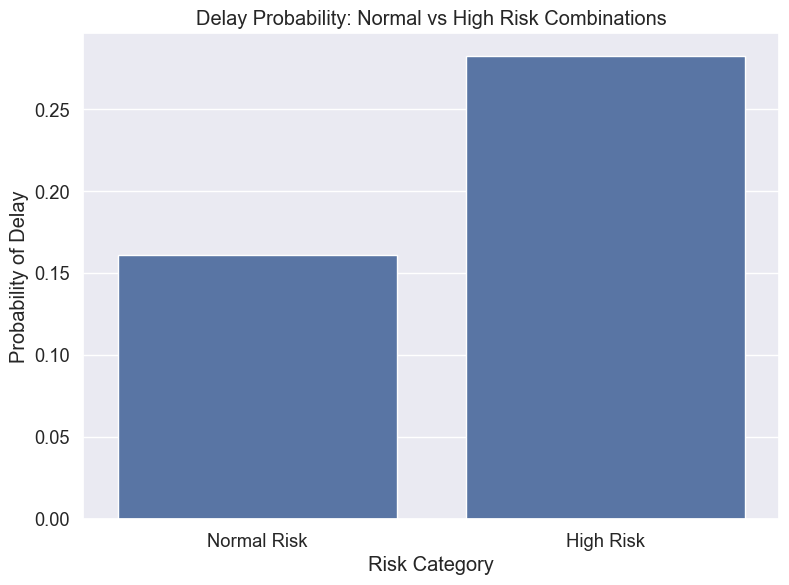

In [24]:
# high risk combination
plt.figure(figsize=(8, 6))
high_risk_labels = ['Normal Risk', 'High Risk']
high_risk_delays = df_full.groupby('high_risk_combo')['dep_delayed_15min'].mean()
sns.barplot(x=[high_risk_labels[i] for i in high_risk_delays.index], y=high_risk_delays.values)
plt.title('Delay Probability: Normal vs High Risk Combinations')
plt.xlabel('Risk Category')
plt.ylabel('Probability of Delay')
plt.show()

<Figure size 1400x800 with 0 Axes>

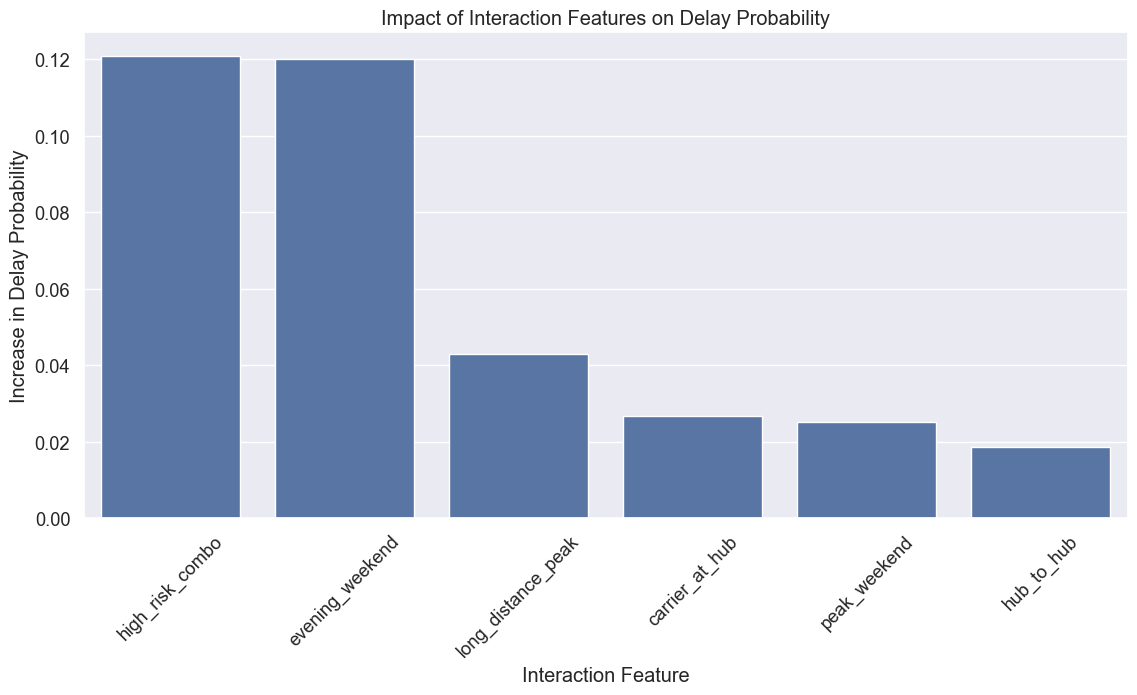

In [25]:
# plot all binary interaction features
binary_features = ['hub_to_hub', 'peak_weekend', 'carrier_at_hub', 'evening_weekend', 'long_distance_peak', 'high_risk_combo']

plt.figure(figsize=(14, 8))
interaction_data = []

for feature in binary_features:
    feature_delays = df_full.groupby(feature)['dep_delayed_15min'].mean()
    delay_diff = feature_delays[1] - feature_delays[0]
    interaction_data.append({
        'Feature': feature,
        'Delay Probability (No)': feature_delays[0],
        'Delay Probability (Yes)': feature_delays[1],
        'Difference': delay_diff
    })

interaction_df = pd.DataFrame(interaction_data).sort_values('Difference', ascending=False)

# plot the differences
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Difference', data=interaction_df)
plt.title('Impact of Interaction Features on Delay Probability')
plt.xlabel('Interaction Feature')
plt.ylabel('Increase in Delay Probability')
plt.xticks(rotation=45)
plt.show()

## 7. Feature Selection and Importance

Let's train a simple model to evaluate feature importance and determine which features are most useful for predicting delays.

In [26]:
# prepare data for modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import joblib

# select features for modeling
# drop non-feature columns or those that would cause data leakage
drop_cols = ['dep_delayed_15min', 'month_day', 'route']  

# create X and y
y = df_full['dep_delayed_15min']
X = df_full.drop(columns=drop_cols)

# handle categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (80000, 645)
Testing data shape: (20000, 645)


In [27]:
# train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# make predictions
y_pred_proba = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

# evaluate
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ROC AUC: 0.7768

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     16222
           1       0.59      0.19      0.28      3778

    accuracy                           0.82     20000
   macro avg       0.71      0.58      0.59     20000
weighted avg       0.79      0.82      0.78     20000



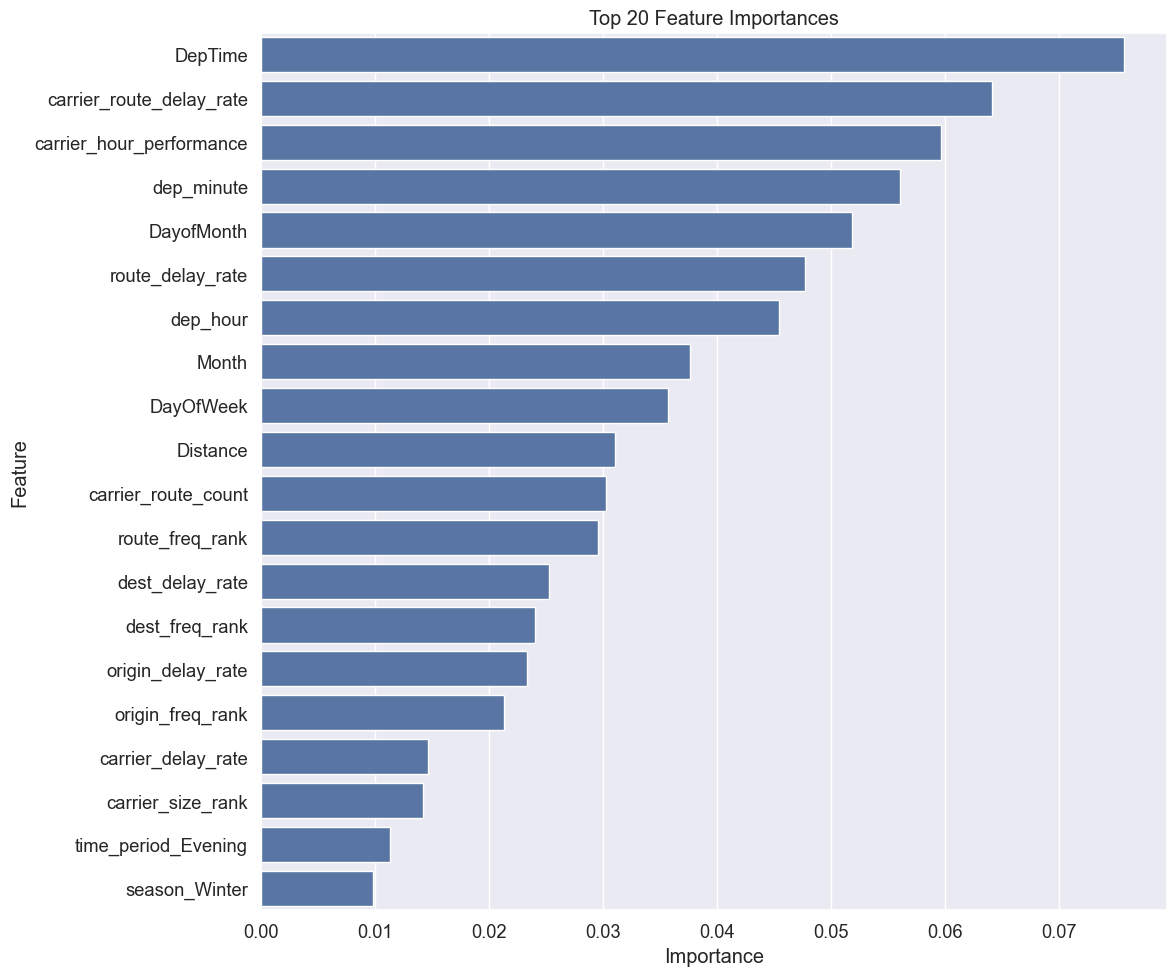

In [28]:
# get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# plot top 20 features
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 8. Preparing Data for Modeling

Now that we've created and evaluated our features, let's prepare the final dataset for modeling.

In [29]:
# select the top features based on importance
top_features = feature_importance['Feature'].head(30).tolist()
X_selected = X_encoded[top_features]

# split the data again
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# train a new model with selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selected.fit(X_train_selected, y_train)

# evaluate
y_pred_proba_selected = rf_selected.predict_proba(X_test_selected)[:, 1]
roc_auc_selected = roc_auc_score(y_test, y_pred_proba_selected)
print(f"ROC AUC with selected features: {roc_auc_selected:.4f}")

ROC AUC with selected features: 0.7975


In [30]:
# Save the full-featured dataset for future modeling
processed_data_path = os.path.join(data_processed, 'flight_delays_features.csv')
df_full.to_csv(processed_data_path, index=False)
print(f"Saved featured dataset to {processed_data_path}")

# Save feature names for consistency in prediction
feature_names_path = os.path.join(project_dir, 'models', 'feature_names.pkl')
os.makedirs(os.path.dirname(feature_names_path), exist_ok=True)
joblib.dump(top_features, feature_names_path)
print(f"Saved top feature names to {feature_names_path}")

Saved featured dataset to /Users/preston/flight_delay_prediction/data/processed/flight_delays_features.csv
Saved top feature names to /Users/preston/flight_delay_prediction/models/feature_names.pkl
